# Proyecto de Serie Temporal Alternativa


Imports

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima import auto_arima
from pickle import dump

In [11]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv"
total_data= pd.read_csv(url)

# Save Data
total_data.to_csv("/workspaces/timeseriesalternative/data/raw/sales.csv", index = False)

In [12]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [13]:
total_data["date"] = pd.to_datetime(total_data["date"]).dt.date
total_data.head(5)

,date,sales
0,2022-09-03,55.292157
1,2022-09-04,53.803211
2,2022-09-05,58.141693
3,2022-09-06,64.530899
4,2022-09-07,66.013633


In [14]:
#convertimos la columna date en índice
total_data.set_index("date", inplace=True)
total_data.head()

,sales
date,
2022-09-03,55.292157
2022-09-04,53.803211
2022-09-05,58.141693
2022-09-06,64.530899
2022-09-07,66.013633


In [15]:
ts = total_data["sales"]
ts

date
2022-09-03      55.292157
2022-09-04      53.803211
2022-09-05      58.141693
2022-09-06      64.530899
2022-09-07      66.013633
                 ...     
2023-08-30     989.600354
2023-08-31     994.987326
2023-09-01     995.814415
2023-09-02     997.350214
2023-09-03    1000.482785
Name: sales, Length: 366, dtype: float64

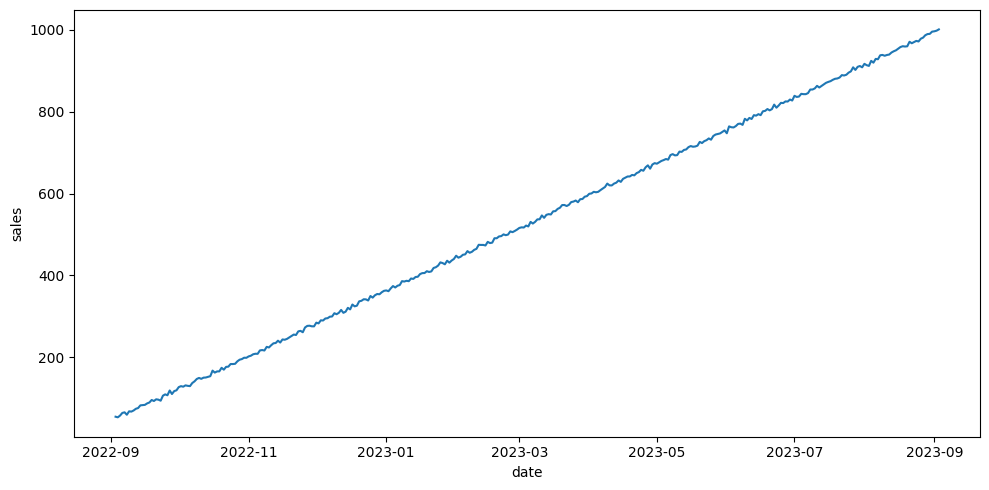

In [16]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)

plt.tight_layout()

plt.show()

En este gráfico podemos observar lo siguiente:

Tendencia: Se aprecia una tendencia alcista, lo que indica un aumento en las ventas con el tiempo.

Estacionalidad: No parece haber estacionalidad en los datos.

Variabilidad: No se observan puntos de variabilidad en la serie temporal.

Outliers: Tras analizar la tendencia y la estacionalidad de la serie temporal, no se identifican valores atípicos.

Puntos de inflexión: No se encuentran puntos de inflexión.

* Descomposición de la serie.

In [17]:
decomposition = seasonal_decompose(ts, period = 12)
decomposition

Tendencia

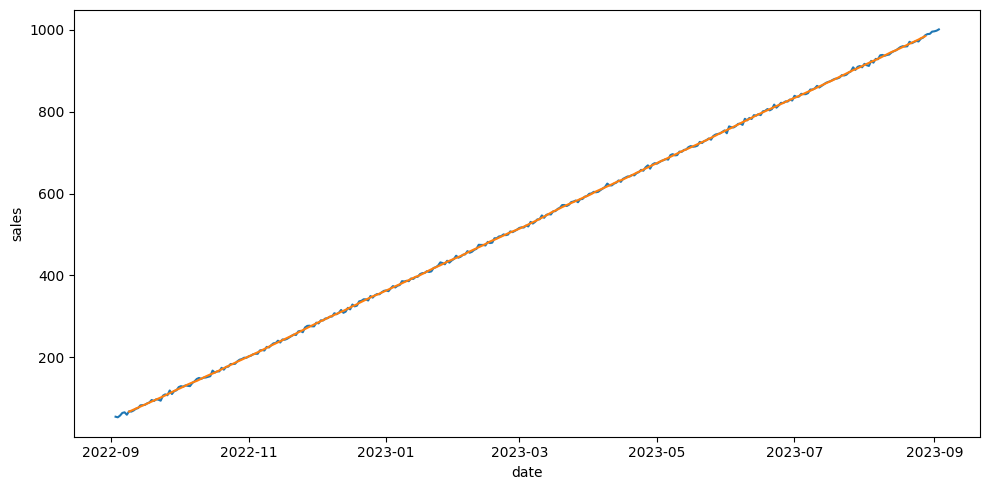

In [18]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

La tendencia es positiva a lo largo del tiempo

* Analisis de estacionalidad

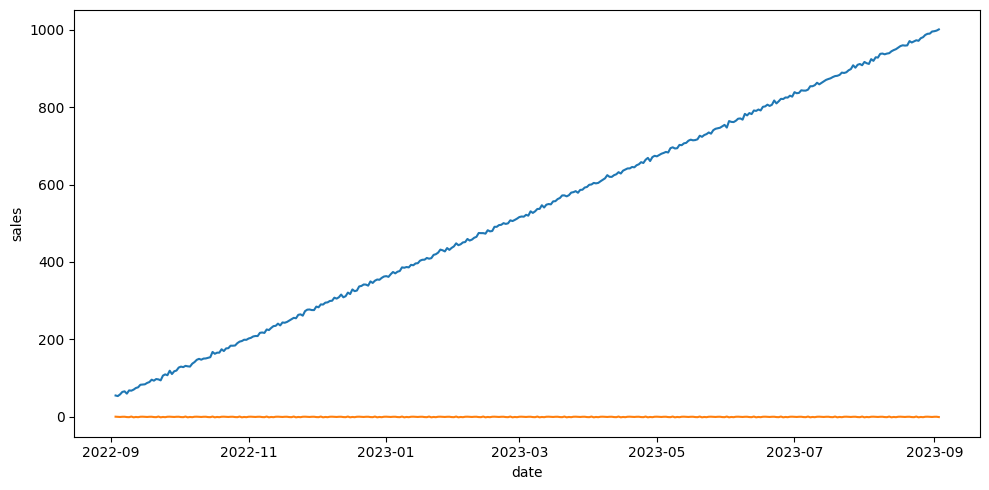

In [19]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

NO existe estacionalidad.

# DICKEY-FULLER

Hipótesis nula (H0): la serie no es estacionaria

Hipótesis alternativa (H1): la serie es estacionaria

In [20]:
def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(ts)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

El valor p obtenido es mayor que 0,05, lo que sugiere que no podemos descartar nuestra hipótesis nula. Por consiguiente, según este resultado, consideramos que esta serie no es estacionaria, tal como se observa.


* ANALISIS DE VARIABILIDAD

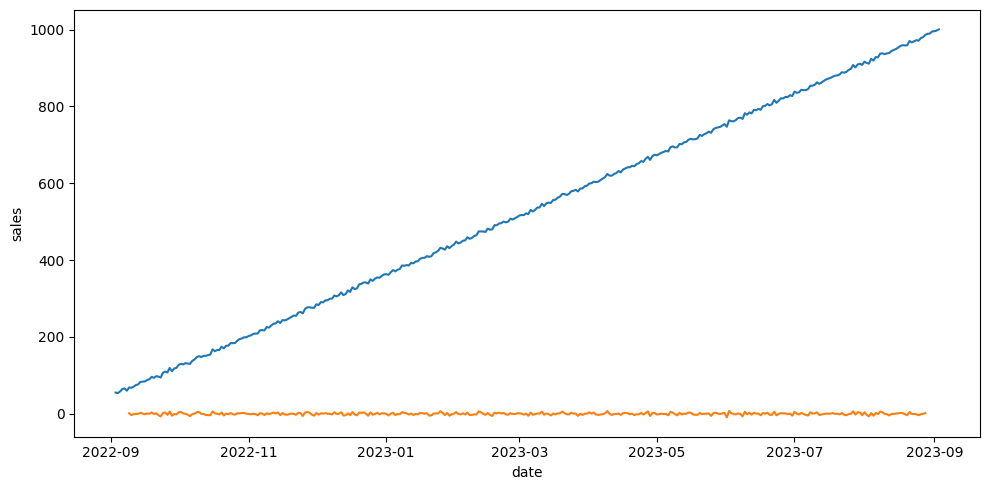

In [21]:
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()

Podemos confirmar que no hay residuos en el período estudiado.

* ANALISIS DE AUTOCORRELACION

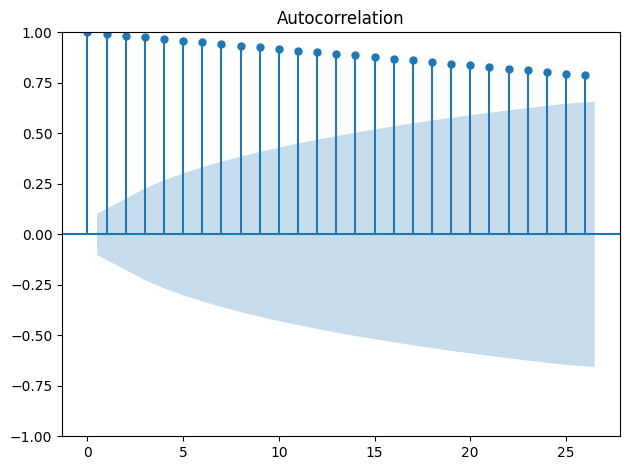

In [22]:
plot_acf(ts)

plt.tight_layout()

plt.show()

Los datos muestran una correlación fuerte que disminuye con el tiempo.

De esto, podemos concluir:

-Patrón de la serie temporal: fluctuaciones diarias.
-Tendencia: crecimiento no lineal.
-Estacionariedad: no es estacionaria.
-Variabilidad o ruido: no hay variabilidad aparente ni ruido.

In [23]:
#transformamos la serie en estacionaria
ts_stationary = ts.diff().dropna()

test_stationarity(ts_stationary)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

## Modelo ARIMA


* ESTACIONARIO

In [24]:
model = auto_arima(ts_stationary, seasonal = True, trace = True, m = 12)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1847.120, Time=1.92 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2096.542, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1972.854, Time=0.24 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2209.657, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=1845.127, Time=1.07 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=1843.049, Time=0.55 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=1845.092, Time=1.55 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=1843.587, Time=0.27 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=1841.533, Time=0.53 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=1843.434, Time=1.79 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=1843.433, Time=1.42 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=2.10 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1839.553, Time=0.23 sec
 ARIMA(1,0,1)(1,0,0)[12] inte

In [26]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -915.776
Date:                Fri, 16 Feb 2024   AIC                           1839.553
Time:                        17:41:52   BIC                           1855.152
Sample:                    09-04-2022   HQIC                          1845.752
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8110      0.134     21.055      0.000       2.549       3.073
ar.L1         -0.0821      0.052     -1.592      0.111      -0.183       0.019
ma.L1         -0.9413      0.020    -47.701      0.000      -0.980      -0.903
sigma2         8.7903      0.688     12.777      0.000       7.442      10.139
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              1.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
#Guardamos
dump(model, open("/workspaces/timeseriesalternative/models/Arima_model_stationary.pk", "wb"))

In [29]:
#predecimos los dias que queramos en ventas
forecast = model.predict(30)
forecast

2023-09-04    1.675366
2023-09-05    2.673520
2023-09-06    2.591621
2023-09-07    2.598341
2023-09-08    2.597789
2023-09-09    2.597834
2023-09-10    2.597831
2023-09-11    2.597831
2023-09-12    2.597831
2023-09-13    2.597831
2023-09-14    2.597831
2023-09-15    2.597831
2023-09-16    2.597831
2023-09-17    2.597831
2023-09-18    2.597831
2023-09-19    2.597831
2023-09-20    2.597831
2023-09-21    2.597831
2023-09-22    2.597831
2023-09-23    2.597831
2023-09-24    2.597831
2023-09-25    2.597831
2023-09-26    2.597831
2023-09-27    2.597831
2023-09-28    2.597831
2023-09-29    2.597831
2023-09-30    2.597831
2023-10-01    2.597831
2023-10-02    2.597831
2023-10-03    2.597831
Freq: D, dtype: float64

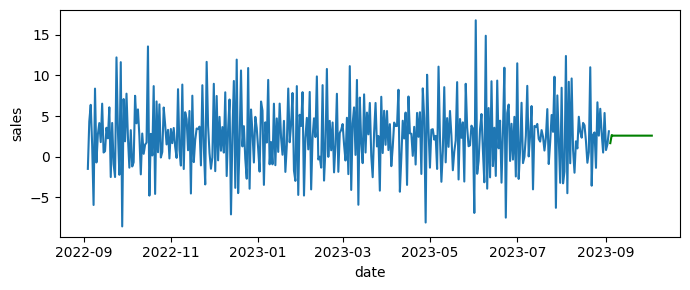

In [31]:
#dibujamos ventas con prediccion
fig, axis = plt.subplots(figsize = (7, 3))

sns.lineplot(data = ts_stationary)
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()

* SIN ESTACIONARIDAD

In [32]:
model = auto_arima(ts, seasonal = False, trace = True, m = 12)

/home/vscode/.local/lib/python3.11/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1843.274, Time=1.76 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2096.542, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1970.972, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1839.586, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2209.657, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1839.552, Time=0.65 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1841.532, Time=1.36 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1843.586, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1839.607, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1922.648, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 5.246 seconds


In [33]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -915.776
Date:                Fri, 16 Feb 2024   AIC                           1839.552
Time:                        17:44:50   BIC                           1855.152
Sample:                    09-03-2022   HQIC                          1845.752
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8110      0.134     21.055      0.000       2.549       3.073
ar.L1         -0.0821      0.052     -1.592      0.111      -0.183       0.019
ma.L1         -0.9413      0.020    -47.701      0.000      -0.980      -0.903
sigma2         8.7903      0.688     12.777      0.000       7.442      10.139
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              1.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
#Guardamos
dump(model, open("/workspaces/timeseriesalternative/models/Arima_model_non_stationary.pk", "wb"))

In [37]:
#prediccion ventas por dias
forecast = model.predict(30)
forecast

2023-09-04    1002.158148
2023-09-05    1004.831669
2023-09-06    1007.423289
2023-09-07    1010.021630
2023-09-08    1012.619419
2023-09-09    1015.217254
2023-09-10    1017.815084
2023-09-11    1020.412915
2023-09-12    1023.010746
2023-09-13    1025.608577
2023-09-14    1028.206409
2023-09-15    1030.804240
2023-09-16    1033.402071
2023-09-17    1035.999902
2023-09-18    1038.597733
2023-09-19    1041.195564
2023-09-20    1043.793395
2023-09-21    1046.391226
2023-09-22    1048.989057
2023-09-23    1051.586888
2023-09-24    1054.184719
2023-09-25    1056.782550
2023-09-26    1059.380381
2023-09-27    1061.978212
2023-09-28    1064.576043
2023-09-29    1067.173874
2023-09-30    1069.771705
2023-10-01    1072.369536
2023-10-02    1074.967367
2023-10-03    1077.565198
Freq: D, dtype: float64

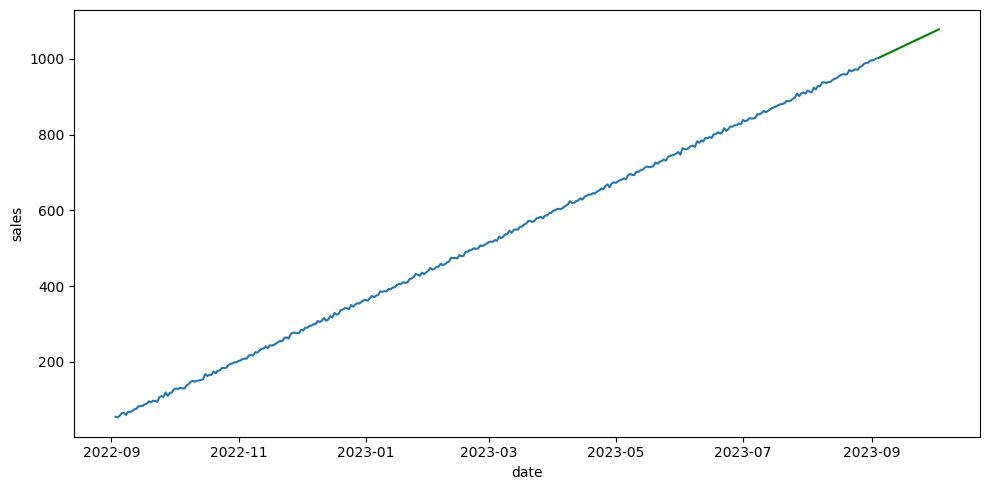

In [38]:
#dibujamos ventas con prediccion
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()

Con estos graficos llegamos a la conclusion que el modelo ARIMA es eficiente con datos no estacionarios.